#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [66]:
# # reset import package
# def reloadPackageOwn():
#     from importlib import reload  
#     import os # we use os.path.join, os.path.basename
#     import sys # we use sys.path
#     import glob # we use glob.glob
#     import importlib # we use importlib.import_module

#     import_folder = os.getcwd()
#     sys.path.append(import_folder) # this tells python to look in `import_folder` for imports
#     for src_file in glob.glob(os.path.join(import_folder, '*.py')):
#         name = os.path.basename(src_file)[:-3]
#         importlib.import_module(name)
#         reload(sys.modules[name])
#         importlib.import_module(name)
        
# reloadPackageOwn()

In [67]:
from tqdm import tqdm
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string
#from process import cek_bfs, nx_to_pyviz

#### Parameter

In [68]:
data=[
    ('1cucu','Cucumovirus','Aphididae','Myzus'),
    ('2cri','Crinivirus','Aleyrodidae','Bemisia'),
    ('3wai','Waikavirus','Cicadellidae','Graminella'),
    ('begomovirus_22_mei','Begomovirus','Aleyrodidae','Bemisia'),
    ('5pol','Polerovirus','Aphididae','Schizaphis'),
    ('+12pol','Polerovirus','Aphididae','Myzus'),
    ('7ort','Orthotospovirus','Thripidae','Frankliniella'),
    ('8capchlo','Orthotospovirus','Thripidae','Thrips Palmi'),
    ('+13Poty','Potyvirus','Aphididae','Myzus'),
    ('9ten','Tenuivirus','Delphacidae','Laodelphax'),
    ('10fiji','Fijivirus','Delphacidae','Sogatella'),
    # error dibawah ini
    ('6pea-nama','Enamovirus','Acyrthosiphon','Acyrthosiphon'),
    ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]


data_,virus_utama,acuan_,ujian_=data[7] # vektor acuan  #data virus
bobot_ed=1;
bobot_dc=1;

In [69]:
# link enpoint sparql ncbi_ontology
endpoint_url = 'http://localhost:3030/mydataset/query'

#### input data

In [70]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [71]:
#reset cuma karena beberapa data kemarin dpe index blum sempat di reset. kalo diweb tidak pake ini
# df_node.reset_index(drop=True,inplace=True)
# df_edge.reset_index(drop=True,inplace=True)

In [72]:
#2
#isi data kosong. mengisi takson kosong, dengan takson sebelumnya, untuk tambalan
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

#### Pengelompokan

In [73]:
# 3
# pengelompokan
# Binning of the data based on serangga, virus, tanaman, nogroup
filter_tanaman = df_node['kingdom']=='NCBI:33090_Viridiplantae' 
filter_virus = (
    (df_node['superkingdom']=='NCBI:10239_Viruses')
    | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
    | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
filter_serangga = ((df_node['class']=='NCBI:50557_Insecta') )#& (df_node['order']!='NCBI:7399_Hymenoptera')) #dan bukan lebah hymenoptera
# df_node['kingdom']=='NCBI:33208_Metazoa' and (df_node['phylum']=='NCBI:6656_Arthropoda' and 
#ini jadi dilema, ada kalau ingin memasukan artropoda lain misal, laba2 maka pake or. untuk saat ini fokus ke insect

df_node.loc[filter_tanaman, ['group','color']] = ["tanaman",'#1f922b'] #hijau
df_node.loc[filter_virus, ['group','color']] = ['virus','#671f92'] #ungu
df_node.loc[filter_serangga, ['group','color']] = ['serangga','#b22222'] #merah
df_node.loc[(
    (filter_tanaman==False) & 
    (filter_virus==False) &
    (filter_serangga==False) 
    ),['group','color']] = ['nogroup','#EADDCA'] #abu-abu

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_60719/296316354.py:7: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_60719/296316354.py:8: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [74]:
# cuma tampilan
import plotly.graph_objects as go

data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

fig = go.Figure(data=[go.Pie(labels=labels,values=slices)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))
fig.show()

In [75]:
slices,labels

([765, 371, 126, 23], ['virus', 'nogroup', 'tanaman', 'serangga'])

In [76]:
#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

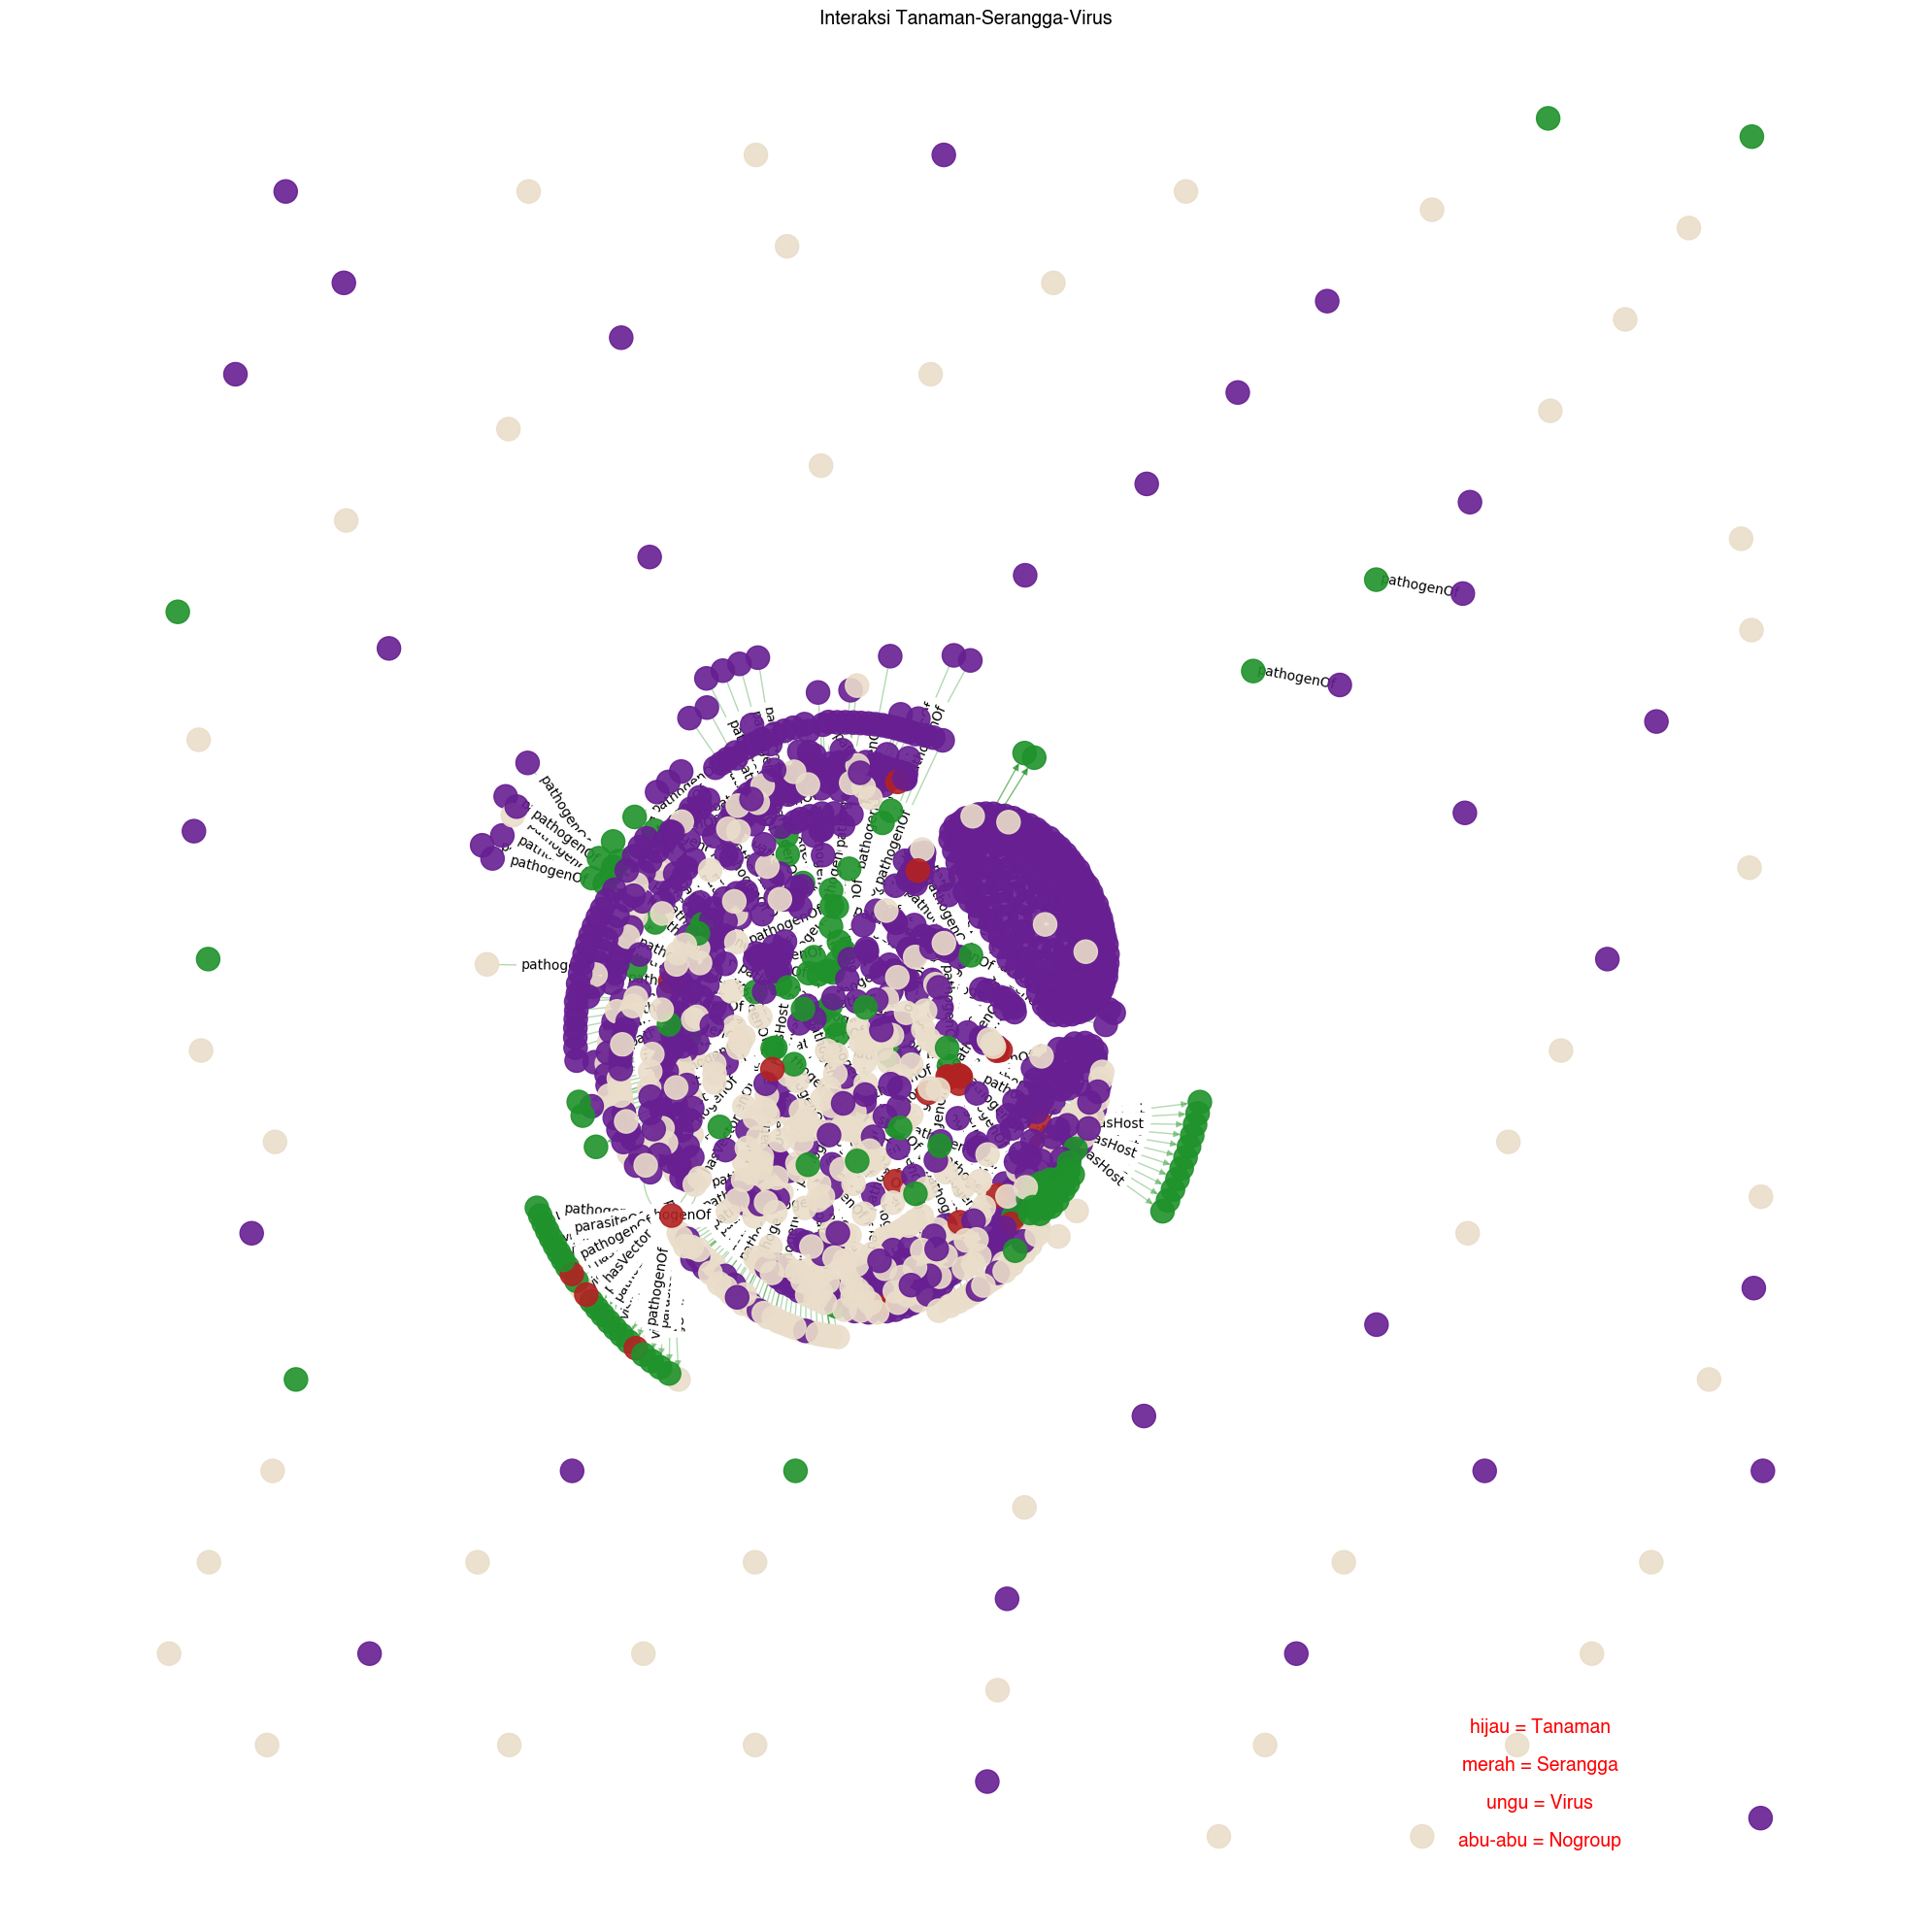

In [77]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Interaksi Tanaman-Serangga-Virus", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [78]:
# cuma tampilan, visualisasi pyviz
from pyvis.network import Network
nt = Network('500px', '900px',directed=True,notebook=True)
# nt.show_buttons(filter_=['physics'])
nt.toggle_physics(True)

for i,data in gnx.nodes(data=True):
    nt.add_node(
        i,
        label= data['label'],
        superkingdom= data['superkingdom'],
        kingdom= data['kingdom'],
        filum= data['filum'],
        kelas= data['kelas'],
        ordo= data['ordo'],
        famili= data['famili'],
        genus= data['genus'],
        spesies= data['spesies'],
        group= data['group'],
        color= data['color'],
        )
    
for s,t,data in gnx.edges(data=True):
    nt.add_edge(
        s,
        t,
        label=data['label'])

# nt.show("tmp.fig02.html")

In [79]:
#4 
# Degree Centrality
results = nx.degree_centrality(gnx)
allnodes = gnx.nodes

In [80]:
# TAMBAHAN UNTUK CEK KUALITAS RELASI SERANGGA
def bfs_relasi_ke_virus_utama(gnx, to_search, virus_utama_ids):
    counter=0
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=2):
        s_id, o_id = edge

        s_label = gnx.nodes[s_id]['label'] +' '+s_id
        o_label = gnx.nodes[o_id]['label'] +' '+o_id

        # skip subjek to_search
        if (s_id == to_search) & (o_id in virus_utama_ids):
            print(s_label,'-->', o_label)
            counter+=1
    
    return counter

# tandai virus utama
search_virus,taxon_,ncbi_id_=cek_ncbi_id_by_wiki_id_via_string(virus_utama)
print("keyword virus utama: ",(search_virus,taxon_,ncbi_id_))
df_node.loc[df_node[taxon_].str.contains(search_virus), ['virus_utama']] = True

# hitung relasi ke virus utama setiap serangga
virus_utama_ids=list(df_node[df_node['virus_utama']==True].taxon_id)
for idx,data in df_node[(df_node['group']=='serangga')].iterrows():
    print(idx,data.taxon_name,data.taxon_id)
    _relasi = bfs_relasi_ke_virus_utama(gnx,data.taxon_id,virus_utama_ids)
    print(_relasi)
    df_node.loc[idx,'relasi_ke_virus_utama'] = _relasi
    print("=================")
    # update DC pake bobot
    # reset_n=(len(gnx.nodes)-1)/(len([node for node, data in gnx.nodes(data=True) if data.get('group') == "serangga"])-1)
    # results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi*reset_n) #1+(CM*w) #kalo pake jumlah serangga sebagai pembagi
    results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi) #1+(CM*w)

keyword virus utama:  ('Orthotospovirus', 'genus', 'NCBI:2560196')
22 Frankliniella occidentalis NCBI:133901
Frankliniella occidentalis NCBI:133901 --> Tomato spotted wilt orthotospovirus NCBI:1933298
1
23 Scirtothrips dorsalis NCBI:163899
Scirtothrips dorsalis NCBI:163899 --> Tomato spotted wilt orthotospovirus NCBI:1933298
1
137 Crocidosema aporema NCBI:581467
0
144 Chrysodeixis chalcites NCBI:749652
0
145 Autographa gamma NCBI:254363
0
146 Diabrotica speciosa NCBI:133126
0
147 Spodoptera litura NCBI:69820
0
148 Spodoptera littoralis NCBI:7109
0
150 Helicoverpa armigera NCBI:29058
0
500 Macrosiphum euphorbiae NCBI:13131
0
506 Neoleucinodes elegantalis NCBI:1511177
0
507 Epiphyas postvittana NCBI:65032
0
537 Tecia solanivora NCBI:396680
0
538 Heteronychus arator NCBI:295550
0
546 Bactericera cockerelli NCBI:290155
0
718 Myzus persicae NCBI:13164
0
757 Heteronemia NCBI:629302
0
1184 Peru NCBI:1634180
0
1273 Thrips tabaci NCBI:161014
Thrips tabaci NCBI:161014 --> Tomato spotted wilt ort

In [81]:
dc_serangga=[]
for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if allnodes[node_id]['group'] in ['serangga']:
        label = gnx.nodes[node_id]['label']
        dc_serangga.append((rank, label, node_id))

In [82]:
dc_serangga

[(1.027258566978193, 'Iris', 'NCBI:444649'),
 (1.0241433021806854, 'Frankliniella occidentalis', 'NCBI:133901'),
 (1.0116822429906542, 'Scirtothrips dorsalis', 'NCBI:163899'),
 (1.0070093457943925, 'Thrips tabaci', 'NCBI:161014'),
 (1.0, 'Crocidosema aporema', 'NCBI:581467'),
 (1.0, 'Chrysodeixis chalcites', 'NCBI:749652'),
 (1.0, 'Autographa gamma', 'NCBI:254363'),
 (1.0, 'Diabrotica speciosa', 'NCBI:133126'),
 (1.0, 'Spodoptera litura', 'NCBI:69820'),
 (1.0, 'Spodoptera littoralis', 'NCBI:7109'),
 (1.0, 'Helicoverpa armigera', 'NCBI:29058'),
 (1.0, 'Macrosiphum euphorbiae', 'NCBI:13131'),
 (1.0, 'Neoleucinodes elegantalis', 'NCBI:1511177'),
 (1.0, 'Epiphyas postvittana', 'NCBI:65032'),
 (1.0, 'Tecia solanivora', 'NCBI:396680'),
 (1.0, 'Heteronychus arator', 'NCBI:295550'),
 (1.0, 'Bactericera cockerelli', 'NCBI:290155'),
 (1.0, 'Myzus persicae', 'NCBI:13164'),
 (1.0, 'Heteronemia', 'NCBI:629302'),
 (1.0, 'Peru', 'NCBI:1634180'),
 (1.0, 'Myzus (Nectarosiphon) persicae', 'NCBI:13163'),

In [83]:
#visualisasi data
# mengecek BFS Degree tertinggi
for to_search  in [dc_serangga[0][2]]:#["NCBI:7038"]:#"NCBI:33377","NCBI:7036",
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=1):
            s_id, o_id = edge

            s_label = gnx.nodes[s_id]['label'] +' '+s_id
            o_label = gnx.nodes[o_id]['label'] +' '+o_id
            o_grup = gnx.nodes[o_id]['group']

            # skip subjek to_search
            # if (o_grup == 'tanaman'):
            print(s_label,'-->', o_label)
    print('===============')

Iris NCBI:444649 --> Iris yellow spot virus NCBI:60456
Iris NCBI:444649 --> Hypericum triquetrifolium NCBI:282558
Iris NCBI:444649 --> Satureja NCBI:49986
Iris NCBI:444649 --> Stachys NCBI:53171
Iris NCBI:444649 --> Echinops NCBI:9369
Iris NCBI:444649 --> Carduus pycnocephalus NCBI:143180
Iris NCBI:444649 --> Acanthus spinosus NCBI:101744
Iris NCBI:444649 --> Fumaria NCBI:200992
Iris NCBI:444649 --> Brassicaceae NCBI:3700
Iris NCBI:444649 --> Castanea sativa NCBI:21020
Iris NCBI:444649 --> Buddleja davidii NCBI:28540
Iris NCBI:444649 --> Larrea tridentata NCBI:66636
Iris NCBI:444649 --> Lantana NCBI:87005
Iris NCBI:444649 --> Puccinia iridis NCBI:1648186
Iris NCBI:444649 --> Hippeastrum NCBI:4668
Iris NCBI:444649 --> Allium sativum NCBI:4682
Iris NCBI:444649 --> Iris NCBI:26378
Iris NCBI:444649 --> Allium NCBI:4678
Iris NCBI:444649 --> Eustoma exaltatum russellianum NCBI:52517
Iris NCBI:444649 --> Allium cepa NCBI:4679
Iris NCBI:444649 --> Thrips tabaci NCBI:161014
Iris NCBI:444649 -->

In [84]:
for i in [dc_serangga[0][2]]:#["NCBI:33377","NCBI:7036","NCBI:7038","NCBI:65032"]:
    print(gnx.nodes[i])

{'label': 'Iris', 'superkingdom': 'NCBI:2759_Eukaryota', 'kingdom': 'NCBI:33208_Metazoa', 'filum': 'NCBI:6656_Arthropoda', 'kelas': 'NCBI:50557_Insecta', 'ordo': 'NCBI:7504_Mantodea', 'famili': 'NCBI:267104_Eremiaphilidae', 'genus': 'NCBI:444649_Iris <mantids>', 'spesies': 'NCBI:444649_Iris <mantids>^species', 'group': 'serangga', 'color': '#b22222'}


In [85]:
#5
# Ambil data NCBI
# data acuan
data_acuan=get_taxon_vector(acuan_,endpoint_url)
print(data_acuan)
data_ujian=get_taxon_vector(ujian_,endpoint_url)
print(data_ujian)

[('famili', 'NCBI:45053_Thripidae'), ('ordo', 'NCBI:30262_Thysanoptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:161013_Thrips palmi'), ('genus', 'NCBI:45057_Thrips'), ('famili', 'NCBI:45053_Thripidae'), ('ordo', 'NCBI:30262_Thysanoptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]


In [86]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

In [87]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

In [88]:
# visualisasi

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X= UMAP().fit_transform(embeddings)
df_umap=pd.DataFrame(X,columns=['feature-vector-1','feature-vector-2'])


text=[]
labels=[]
for x in transformer._entities:
    if(x!="http://pyRDF2Vec#SERANGGA_ACUAN"):
        text.append(gnx.nodes[x.split("#")[-1]]['famili'].split('_')[-1])
        labels.append(gnx.nodes[x.split("#")[-1]]['label'])
    else:
        text.append("#TITIK_VEKTOR_ACUAN")
        labels.append("#TITIK_VEKTOR_ACUAN")
df_umap['text']=text
df_umap['labels']=labels

# # gnx.nodes[x.split("#")[-1]]['label']
# df_umap['text']=list(map(lambda x: x.split("#")[-1],transformer._entities))
fig = px.scatter(df_umap, x='feature-vector-1',y='feature-vector-2',text='text',hover_name='labels')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=650,
    title_text='reduced word2vec visualization'
)
fig.show()

In [89]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

# minmax scaling dc dan ed
from sklearn.preprocessing import MinMaxScaler
for i in ['dc_result', 'ed_result']:
    scaler = MinMaxScaler()
    scaler.fit(data_to_count[i].to_numpy().reshape(1, -1))
    scaler.transform(data_to_count[i].to_numpy().reshape(1, -1))

In [90]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [91]:
#9
#hitung kombinasi
for idx, row in data_to_count.iterrows():
    _dc = row['dc_result']
    _ed=( (row['ed_result']) if row['ed_result']!=0 else 1)
    data_to_count.loc[idx,['result']] = _dc/_ed
    
# urutkan
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count[['label','dc_result','ed_result','result']]

,label,dc_result,ed_result,result
0,Scirtothrips dorsalis,1.011682,0.085218,11.871643
1,Thrips tabaci,1.007009,0.092369,10.901969
2,Macrosiphum (Macrosiphum) euphorbiae,1.000000,0.119385,8.376271
3,Frankliniella occidentalis,1.024143,0.122714,8.345785
4,Myzus persicae,1.000000,0.142731,7.006176
5,Myzus (Nectarosiphon) persicae,1.000000,0.154122,6.488385
6,Chrysodeixis chalcites,1.000000,0.154596,6.468475
7,Crocidosema aporema,1.000000,0.164984,6.061188
8,Macrosiphum euphorbiae,1.000000,0.171661,5.825422
9,Autographa gamma,1.000000,0.180321,5.545671


In [92]:
# df_node[df_node.taxon_id.isin(['NCBI:7036',
# 'NCBI:33377',
# 'NCBI:7038',
# 'NCBI:1634180',
# 'NCBI:137042',
# 'NCBI:253718',])]

# Hemiptera
# Aleyrodidae

# Orthoptera
# Phalangopsidae
# Peru


# Hymenoptera
# Crabronidae
# Lithium




In [93]:
data_to_count[['label','dc_result']].sort_values('dc_result',ascending=False).reset_index(drop=True)

,label,dc_result
0,Iris,1.027259
1,Frankliniella occidentalis,1.024143
2,Scirtothrips dorsalis,1.011682
3,Thrips tabaci,1.007009
4,Spodoptera littoralis,1.000000
5,Heteronemia,1.000000
6,Diabrotica speciosa,1.000000
7,Heteronychus arator,1.000000
8,Bactericera cockerelli,1.000000
9,Orchamoplatus citri,1.000000


In [94]:
data_to_count[['label','entity','ed_result']].sort_values('ed_result',ascending=True).reset_index(drop=True)

,label,entity,ed_result
0,Scirtothrips dorsalis,NCBI:163899,0.085218
1,Thrips tabaci,NCBI:161014,0.092369
2,Macrosiphum (Macrosiphum) euphorbiae,NCBI:13130,0.119385
3,Frankliniella occidentalis,NCBI:133901,0.122714
4,Myzus persicae,NCBI:13164,0.142731
5,Myzus (Nectarosiphon) persicae,NCBI:13163,0.154122
6,Chrysodeixis chalcites,NCBI:749652,0.154596
7,Crocidosema aporema,NCBI:581467,0.164984
8,Macrosiphum euphorbiae,NCBI:13131,0.171661
9,Autographa gamma,NCBI:254363,0.180321


In [95]:
allnodes['NCBI:444649']

{'label': 'Iris',
 'superkingdom': 'NCBI:2759_Eukaryota',
 'kingdom': 'NCBI:33208_Metazoa',
 'filum': 'NCBI:6656_Arthropoda',
 'kelas': 'NCBI:50557_Insecta',
 'ordo': 'NCBI:7504_Mantodea',
 'famili': 'NCBI:267104_Eremiaphilidae',
 'genus': 'NCBI:444649_Iris <mantids>',
 'spesies': 'NCBI:444649_Iris <mantids>^species',
 'group': 'serangga',
 'color': '#b22222'}

# Pengujian

In [106]:
takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
id_hasil=data_to_count.iloc[0].entity
cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
cek_ujian= { k:v for k,v in data_ujian if k in takson }

print(acuan_,'->', data_)
print('ujian ',cek_ujian)
print('hasil ',cek_hasil)

cek=0
for i in reversed(takson):
    cekk=cek_hasil[i]==cek_ujian[i]
    cek+=cekk
    print(i, cekk)


print(cek/len(takson))

Thripidae -> 8capchlo
ujian  {'spesies': 'NCBI:161013_Thrips palmi', 'genus': 'NCBI:45057_Thrips', 'famili': 'NCBI:45053_Thripidae', 'ordo': 'NCBI:30262_Thysanoptera'}
hasil  {'spesies': 'NCBI:163899_Scirtothrips dorsalis', 'genus': 'NCBI:163898_Scirtothrips', 'famili': 'NCBI:45053_Thripidae', 'ordo': 'NCBI:30262_Thysanoptera'}
ordo True
famili True
genus False
spesies False
0.5


In [97]:
data_ujian

[('spesies', 'NCBI:161013_Thrips palmi'),
 ('genus', 'NCBI:45057_Thrips'),
 ('famili', 'NCBI:45053_Thripidae'),
 ('ordo', 'NCBI:30262_Thysanoptera'),
 ('kelas', 'NCBI:50557_Insecta'),
 ('filum', 'NCBI:6656_Arthropoda'),
 ('kingdom', 'NCBI:33208_Metazoa'),
 ('superkingdom', 'NCBI:2759_Eukaryota')]

In [98]:
data_acuan

[('famili', 'NCBI:45053_Thripidae'),
 ('ordo', 'NCBI:30262_Thysanoptera'),
 ('kelas', 'NCBI:50557_Insecta'),
 ('filum', 'NCBI:6656_Arthropoda'),
 ('kingdom', 'NCBI:33208_Metazoa'),
 ('superkingdom', 'NCBI:2759_Eukaryota')]

In [99]:
ujian_

'Thrips Palmi'